<a href="https://colab.research.google.com/github/Togrofi/uncertainties-exam/blob/main/UncertaintiesExam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.nn import Parameter
from torch.utils.data import Subset, DataLoader, RandomSampler, SubsetRandomSampler
from torch.optim import Adam, SGD
from tqdm import tqdm
from hyperopt import hp, tpe, fmin
from datetime import datetime


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

params = {
    'beta': 1,
    'proportion_of_dataset': 1,
    'threshold': 0.1,
    'num_epochs': 10,
    'batch_size': 256,
    'experiment_name': 'split', # 'split', 'permuted', 'custom'
    'perform_baseline': True,
    'perform_custom': True,
}

split_params = {
    'hidden_dim': 256
}

permuted_params = {
    'hidden_dim': 100
}

custom_params = {
    'num_clients': 10,
}

baseline_params = {
    'num_tasks': 5,
}


# Data

In [ ]:
#@title Create Permuted Data
def get_permuted_dataloaders(num_tasks, batch_size=256):
    dataset = datasets.MNIST
    dataloaders = []

    for task in range(num_tasks):
        if task == 0:
            transform = transforms.Compose([
                transforms.Resize((28, 28)),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
        else:
            rng_permute = np.random.RandomState(task)
            idx_permute = torch.from_numpy(rng_permute.permutation(28*28))
            transform = transforms.Compose([
                transforms.Resize((28, 28)),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                transforms.Lambda(lambda x, idx=idx_permute: x.view(-1)[idx].view(1, 28, 28))
            ])

        full_task_trainset = dataset(root="./data", train=True, download=True, transform=transform)
        jump_size = int(1 / params['proportion_of_dataset'])
        task_trainset = Subset(full_task_trainset, range(0, len(full_task_trainset), jump_size))
        task_train_sampler = RandomSampler(task_trainset)
        task_train_loader = DataLoader(task_trainset, batch_size=batch_size, sampler=task_train_sampler)

        full_task_testset = dataset(root="./data", train=False, download=True, transform=transform)
        jump_size = int(1 / params['proportion_of_dataset'])
        task_testset = Subset(full_task_testset, range(0, len(full_task_testset), jump_size))
        task_test_sampler = RandomSampler(task_testset)
        task_test_loader = DataLoader(task_testset, batch_size=batch_size, sampler=task_test_sampler)

        dataloaders.append((task_train_loader, task_test_loader))

    return dataloaders


In [ ]:
#@title Create Split Data
def _extract_class_specific_idx(dataset, target_classes):
    idx = torch.zeros_like(dataset.targets, dtype=torch.bool)
    for target in target_classes:
        idx = idx | (dataset.targets==target)

    return idx

def get_split_dataloaders(class_distribution, batch_size=256):
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])

    dataset = datasets.MNIST
    trainset = dataset(root="./data", train=True, download=True, transform=transform)
    testset = dataset(root="./data", train=False, download=True, transform=transform)

    dataloaders = []

    for i, classes in enumerate(class_distribution):
        offset = 2 * i
        train_idx = _extract_class_specific_idx(trainset, classes)
        train_idx = torch.where(train_idx)[0]
        sub_train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        sub_train_loader = torch.utils.data.DataLoader(
            trainset, batch_size=batch_size, sampler=sub_train_sampler)
        trainset.targets[sub_train_sampler.indices] -= offset

        test_idx = _extract_class_specific_idx(testset, classes)
        test_idx = torch.where(test_idx)[0]
        sub_test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)
        sub_test_loader = torch.utils.data.DataLoader(
            testset, batch_size=batch_size, sampler=sub_test_sampler)
        testset.targets[sub_test_sampler.indices] -= offset

        dataloaders.append((sub_train_loader, sub_test_loader))

    return dataloaders

def get_split_dataloaders2(class_distribution, num_clients, batch_size=256):
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])

    dataset = datasets.MNIST
    trainset = dataset(root="./data", train=True, download=True, transform=transform)
    testset = dataset(root="./data", train=False, download=True, transform=transform)

    dataloaders = []

    for i, classes in enumerate(class_distribution):
        offset = 2 * i
        train_idx = _extract_class_specific_idx(trainset, classes)
        train_idx = torch.where(train_idx)[0]
        sub_train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        sub_train_loader = torch.utils.data.DataLoader(
            trainset, batch_size=batch_size, sampler=sub_train_sampler)
        trainset.targets[sub_train_sampler.indices] -= offset

        test_idx = _extract_class_specific_idx(testset, classes)
        test_idx = torch.where(test_idx)[0]
        sub_test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)
        sub_test_loader = torch.utils.data.DataLoader(
            testset, batch_size=batch_size, sampler=sub_test_sampler)
        testset.targets[sub_test_sampler.indices] -= offset

        dataloaders.append((sub_train_loader, sub_test_loader))

    random.shuffle(dataloaders)

    return dataloaders


# Custom Models

In [ ]:
#@title Custom Layer
def KL_DIV(mu_p, sig_p, mu_q, sig_q):
    kl = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()
    return kl

class BBBLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, priors=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = bias

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.01,
            }

        self.prior_W_mu = torch.tensor(priors['prior_mu'])
        self.prior_W_sigma = torch.tensor(priors['prior_sigma'])
        self.prior_bias_mu = torch.tensor(priors['prior_mu'])
        self.prior_bias_sigma = torch.tensor(priors['prior_sigma'])

        self.W_mu = Parameter(torch.Tensor(out_features, in_features))
        self.W_rho = Parameter(torch.Tensor(out_features, in_features))
        if self.use_bias:
            self.bias_mu = Parameter(torch.Tensor(out_features))
            self.bias_rho = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(0, 0.1)
        self.W_rho.data.fill_(-3)

        if self.use_bias:
            self.bias_mu.data.normal_(0, 0.1)
            self.bias_rho.data.fill_(-3)

    def forward(self, x, sample=True):
        self.W_sigma = torch.log1p(torch.exp(self.W_rho))
        if self.use_bias:
            self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
            bias_var = self.bias_sigma ** 2
        else:
            self.bias_sigma = bias_var = None

        act_mu = F.linear(x, self.W_mu, self.bias_mu)
        # What is this line?
        act_var = 1e-16 + F.linear(x ** 2, self.W_sigma ** 2, bias_var)
        act_std = torch.sqrt(act_var)

        if self.training or sample:
            eps = torch.empty(act_mu.size()).normal_(0, 1).to(act_mu.device)
            return act_mu + act_std * eps
        else:
            return act_mu

    def kl_loss(self):
        kl = KL_DIV(self.prior_W_mu, self.prior_W_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            kl += KL_DIV(self.prior_bias_mu, self.prior_bias_sigma, self.bias_mu, self.bias_sigma)
        return kl

In [ ]:
#@title Dynamic Head Model

class DynamicHeadModel(nn.Module):
    def __init__(self, input_size=28*28, hidden_dim=100, hidden_layers=2):
        super().__init__()
        self.input_layer = BBBLinear(input_size, hidden_dim)
        self.shared_layers = nn.ModuleList([BBBLinear(hidden_dim, hidden_dim) for _ in range(hidden_layers)])
        self.hidden_dim = hidden_dim

        # Initially empty, will create new heads dynamically as batches come in.
        self.head_layers = nn.ModuleList()
        self.num_heads = 0

        # Create a lookup dictionary so that each batch index is linked to the
        # index of the head that gets used on that batch (unlike in the VCL paper
        # there is not necessarily one head per batch).
        self.client_id_to_head_id = {}

    def forward(self, x, id, use_client_id=False):
        head_id = self.client_id_to_head_id[id] if use_client_id else id

        x = x.view(-1, 784)
        x = F.relu(self.input_layer(x))

        for layer in self.shared_layers:
            x = F.relu(layer(x))

        head_to_use = self.head_layers[head_id]

        return head_to_use(x)

    def create_new_head(self, client_id, width):
        print('\nCreating a new head!')
        new_head_id = len(self.head_layers) # 0 if no head layers yet, 1 if there is 1 etc
        self.client_id_to_head_id[client_id] = new_head_id
        self.head_layers.append(BBBLinear(self.hidden_dim, width).to(device))
        self.num_heads += 1

    def get_kl(self, id, use_client_id=False):
        head_id = self.client_id_to_head_id[id] if use_client_id else id
        kl = 0.0
        kl += self.input_layer.kl_loss()
        for layer in self.shared_layers:
            kl += layer.kl_loss()

        kl += self.head_layers[head_id].kl_loss()

        return kl

    def update_prior(self):
        for child in self.children():
            if child.__class__ is not nn.ModuleList:
                child.prior_W_mu = child.W_mu.data
                child.prior_W_sigma = child.W_sigma.data
                if child.use_bias:
                    child.prior_bias_mu = child.bias_mu.data
                    child.prior_bias_sigma = child.bias_sigma.data
            if child.__class__ is nn.ModuleList:
                for layer in child:
                    layer.prior_W_mu = layer.W_mu.data
                    layer.prior_W_sigma = layer.W_sigma.data
                    if layer.use_bias:
                        layer.prior_bias_mu = layer.bias_mu.data
                        layer.prior_bias_sigma = layer.bias_sigma.data

# Baseline Models

In [ ]:
#@title Baseline Permuted Model
class PermutedModel(nn.Module):
    def __init__(self, input_size=28*28, hidden_dim=100, output_dim=10):
        self.input_size = input_size
        super().__init__()
        self.fc1 = BBBLinear(input_size, hidden_dim)
        self.fc2 = BBBLinear(hidden_dim, hidden_dim)
        self.head_layer = BBBLinear(hidden_dim, output_dim)

    def forward(self, x, task_id, use_client_id=False):
        out = x.view(-1, self.input_size)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        return self.head_layer(out)

    def get_kl(self, task_id):
        kl = 0.0
        kl += self.fc1.kl_loss()
        kl += self.fc2.kl_loss()
        kl += self.head_layer.kl_loss()
        return kl

    def update_prior(self):
        self.fc1.prior_W_mu = self.fc1.W_mu.data
        self.fc1.prior_W_sigma = self.fc1.W_sigma.data
        if self.fc1.use_bias:
            self.fc1.prior_bias_mu = self.fc1.bias_mu.data
            self.fc1.prior_bias_sigma = self.fc1.bias_sigma.data

        self.fc2.prior_W_mu = self.fc2.W_mu.data
        self.fc2.prior_W_sigma = self.fc2.W_sigma.data
        if self.fc2.use_bias:
            self.fc2.prior_bias_mu = self.fc2.bias_mu.data
            self.fc2.prior_bias_sigma = self.fc2.bias_sigma.data

        self.head_layer.prior_W_mu = self.head_layer.W_mu.data
        self.head_layer.prior_W_sigma = self.head_layer.W_sigma.data
        if self.head_layer.use_bias:
            self.head_layer.prior_bias_mu = self.head_layer.bias_mu.data
            self.head_layer.prior_bias_sigma = self.head_layer.bias_sigma.data

In [ ]:
#@title Baseline Split Model
class SplitModel(nn.Module):
    def __init__(self, input_size=28*28, hidden_dim=100, output_dim=2):
        self.input_size = input_size
        super().__init__()
        self.fc1 = BBBLinear(input_size, hidden_dim)
        self.fc2 = BBBLinear(hidden_dim, hidden_dim)
        self.head_layers = nn.ModuleList([BBBLinear(hidden_dim, output_dim) for i in range(5)])

    def forward(self, x, task_id, use_client_id=False):
        out = x.view(-1, self.input_size)
        for layer in self.children():
            if layer.__class__ is not nn.ModuleList:
                out = F.relu(layer(out))
        return self.head_layers[task_id](out)

    def get_kl(self, task_id):
        kl = 0.0
        for layer in self.children():
            if layer.__class__ is not nn.ModuleList:
                kl += layer.kl_loss()
        kl += self.head_layers[task_id].kl_loss()
        return kl

    def update_prior(self):
        for layer in self.children():
            if layer.__class__ is not nn.ModuleList:
                layer.prior_W_mu = layer.W_mu.data
                layer.prior_W_sigma = layer.W_sigma.data
                if layer.use_bias:
                    layer.prior_bias_mu = layer.bias_mu.data
                    layer.prior_bias_sigma = layer.bias_sigma.data

# Utils

In [ ]:
#@title Coreset
def attach_random_coreset_permuted(coresets, sub_train_loader, num_samples=200):
    """
    coresets: list of collection of coreset dataloaders
    sub_train_loader: loader from which a random coreset is to be drawn
    num_samples: number of samples in each coreset
    """
    shuffled_task_indices = torch.randperm(len(sub_train_loader.dataset))
    coreset_indices = shuffled_task_indices[:num_samples]
    coreset_sampler = SubsetRandomSampler(coreset_indices)
    coreset_loader = DataLoader(
        sub_train_loader.dataset, batch_size=sub_train_loader.batch_size, sampler=coreset_sampler
    )
    coresets.append(coreset_loader)

def attach_random_coreset_split(coresets, sub_train_loader, num_samples=200):
    """
    coresets: list of collection of coreset dataloaders
    sub_train_loader: loader from which a random coreset is to be drawn
    num_samples: number of samples in each coreset
    """
    task_indices = sub_train_loader.sampler.indices
    shuffled_task_indices = task_indices[torch.randperm(len(task_indices))]
    coreset_indices = shuffled_task_indices[:num_samples]
    sub_train_loader.sampler.indices = shuffled_task_indices[num_samples:]  # Delete coreset from orginal data
    coreset_sampler = torch.utils.data.SubsetRandomSampler(coreset_indices)
    coreset_loader = torch.utils.data.DataLoader(
        sub_train_loader.dataset, batch_size=sub_train_loader.batch_size, sampler=coreset_sampler)
    coresets.append(coreset_loader)


In [ ]:
#@title ELBO
class ELBO(nn.Module):
    def __init__(self, model, beta):
        super().__init__()
        self.num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        self.beta = beta

    def forward(self, outputs, targets, kl):
        assert not targets.requires_grad
        #print(F.nll_loss(outputs, targets, reduction='mean'), self.beta * kl / self.num_params)
        # This should only be divided by the number of paramters that were used (in the appropriate head).
        return F.nll_loss(outputs, targets, reduction='mean') + self.beta * kl / self.num_params

def calculate_accuracy(outputs, targets):
    return np.mean(outputs.argmax(dim=-1).cpu().numpy() == targets.cpu().numpy())


In [ ]:
#@title Get Probability of Head Being the Correct One
def get_probability_of_head(model, dataloader, head_id):
    inputs  = torch.cat([i for i, _ in dataloader]).to(device)
    targets = torch.cat([t.flatten() for _, t in dataloader]).to(device)
    output_nodes = torch.max(targets).item() + 1
    log_output = monte_carlo(model, inputs, output_nodes, head_id)
    loss = F.nll_loss(log_output, targets, reduction='mean')
    probability = torch.exp(-loss)
    return probability

In [ ]:
#@title Monte Carlo
def monte_carlo(model, inputs, output_nodes, id, use_client_id=False, no_grad=False):
    T = 10
    outputs = torch.zeros(inputs.shape[0], output_nodes, T).to(device)

    for i in range(T):
        if no_grad:
            with torch.no_grad():
                out = model(inputs, id, use_client_id)
        else:
            out = model(inputs, id, use_client_id)
        outputs[:, :, i] = F.log_softmax(out, dim=-1)

    log_output = torch.logsumexp(outputs, dim=-1) - np.log(T)

    return log_output


# VCL Methods

In [ ]:
#@title Dynamic Train and Predict
def dynamic_train(model, num_epochs, dataloader, client_id, beta, replay=False):
    beta = 0 if replay else beta
    lr_start = 1e-3

    flattened_tensor = torch.cat([t for _, t in dataloader])
    output_nodes = torch.max(flattened_tensor).item() + 1

    elbo = ELBO(model, beta)
    optimizer = Adam(model.parameters(), lr=lr_start)

    head_loss = None

    model.train()
    for epoch in tqdm(range(num_epochs)):
    #for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)
            # Check if we have identified this client_id with a certain head already:
            if client_id not in model.client_id_to_head_id.keys():
                # Otherwise, we need to find which head to use.
                # First, calculate the loss for each existing head:
                most_promising_head_id   = None
                most_promising_head_prob = 0
                for head_id, head in enumerate(model.head_layers):
                    if head.out_features == output_nodes:
                        prob_of_this_head = get_probability_of_head(model, dataloader, head_id)
                        if prob_of_this_head > most_promising_head_prob:
                            most_promising_head_id   = head_id
                            most_promising_head_prob = prob_of_this_head

                print(most_promising_head_prob)

                # If the results are too poor, create a new head for it
                # and calculate the loss on this new head.
                if most_promising_head_prob <= params['threshold']:
                    # We couldn't find a strong head, so make a new one.
                    model.create_new_head(client_id, output_nodes)
                else:
                    model.client_id_to_head_id[client_id] = most_promising_head_id

            log_output = monte_carlo(model, inputs, output_nodes, client_id, use_client_id=True)
            kl = model.get_kl(client_id, use_client_id=True)
            head_loss = elbo(log_output, targets, kl)
            head_loss.backward()
            optimizer.step()

def dynamic_predict(model, dataloader, client_id):
    model.eval()
    accs = []

    flattened_tensor = torch.cat([t.flatten() for _, t in dataloader])
    output_nodes = torch.max(flattened_tensor).item() + 1

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        #outputs = torch.zeros(inputs.shape[0], output_nodes, model.num_heads).to(device)
#
        #for i in range(model.num_heads):
        #    with torch.no_grad():
        #        out = model(inputs, client_id, use_client_id=True)
        #    outputs[:, :, i] = F.log_softmax(out, dim=-1)
#
        #log_output = torch.logsumexp(outputs, dim=-1) - np.log(model.num_heads)
        log_output = monte_carlo(model, inputs, output_nodes, client_id, use_client_id=True, no_grad=True)
        accs.append(calculate_accuracy(log_output, targets))

    return np.mean(accs)


In [ ]:
#@title Dynamic VCL
def dynamic_vcl(num_epochs, dataloaders, model, coreset_method, coreset_size=0, beta=1., update_prior=True):
    num_batches = len(dataloaders)
    coreset_list = []
    all_accs = np.empty(shape=(num_batches, num_batches))
    all_accs.fill(np.nan)

    for client_id, (trainloader, testloader) in enumerate(dataloaders):
        # Train on non-coreset data
        dynamic_train(model, num_epochs, trainloader, client_id, beta)
        print("Done Training Task", client_id + 1)

        # Attach a new coreset
        if coreset_size > 0:
            coreset_method(coreset_list, trainloader, num_samples=coreset_size)

            # Replay old tasks using coresets
            for task in range(client_id + 1):
                print("Replaying Task", task + 1)
                dynamic_train(model, num_epochs, coreset_list[task], task, beta, replay=True)
        print()

        # Evaluate on old tasks
        for client_to_retest_id in range(client_id + 1):
            _, testloader_i = dataloaders[client_to_retest_id]
            accuracy = dynamic_predict(model, testloader_i, client_to_retest_id)
            print("Task {} Accuracy: {}".format(client_to_retest_id + 1, accuracy))
            all_accs[client_id][client_to_retest_id] = accuracy
        print()

        if update_prior:
            model.update_prior()
    print(all_accs)
    return all_accs

In [ ]:
#@title Baseline Train and Predict
def baseline_train(model, num_epochs, dataloader, task_id, replay=False):
    beta = 0 if replay else 1
    lr_start = 1e-3

    flattened_tensor = torch.cat([t.flatten() for _, t in dataloader])
    output_nodes = torch.max(flattened_tensor).item() + 1

    elbo = ELBO(model, beta)
    optimizer = Adam(model.parameters(), lr=lr_start)

    model.train()
    for epoch in tqdm(range(num_epochs)):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)
            #outputs = torch.zeros(inputs.shape[0], output_nodes, T, device=device)
#
            #for i in range(T):
            #    net_out = model(inputs, task_id)
            #    outputs[:, :, i] = F.log_softmax(net_out, dim=-1)
#
            #log_output = torch.logsumexp(outputs, dim=-1) - np.log(T)
            log_output = monte_carlo(model, inputs, output_nodes, task_id)

            kl = model.get_kl(task_id)
            loss = elbo(log_output, targets, kl)
            loss.backward()
            optimizer.step()

def baseline_predict(model, dataloader, task_id):
    flattened_tensor = torch.cat([t.flatten() for _, t in dataloader])
    output_nodes = torch.max(flattened_tensor).item() + 1

    model.train()
    accs = []
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        #outputs = torch.zeros(inputs.shape[0], output_nodes, T, device=device)

        #for i in range(T):
        #    with torch.no_grad():
        #        net_out = model(inputs, task_id)
        #    outputs[:, :, i] = F.log_softmax(net_out, dim=-1)

        #log_output = torch.logsumexp(outputs, dim=-1) - np.log(T)
        log_output = monte_carlo(model, inputs, output_nodes, task_id, no_grad=True)
        accs.append(calculate_accuracy(log_output, targets))

    return np.mean(accs)


In [ ]:
#@title Baseline VCL
def baseline_vcl(num_tasks, num_epochs, dataloaders, model, coreset_method, coreset_size=0, update_prior=True):
    coreset_list = []
    all_accs = np.empty(shape=(num_tasks, num_tasks))
    all_accs.fill(np.nan)
    for task_id in range(num_tasks):
        print("Starting Task", task_id + 1)

        # Train on non-coreset data
        trainloader, testloader = dataloaders[task_id]
        baseline_train(model, num_epochs, trainloader, task_id)
        print("Done Training Task", task_id + 1)

        # Attach a new coreset
        if coreset_size > 0:
            coreset_method(coreset_list, trainloader, num_samples=coreset_size)

            # Replay old tasks using coresets
            for task in range(task_id + 1):
                print("Replaying Task", task + 1)
                baseline_train(model, num_epochs, coreset_list[task], task_id=task, replay=True)
        print()

        # Evaluate on old tasks
        for task in range(task_id + 1):
            _, testloader_i = dataloaders[task]
            accuracy = baseline_predict(model, testloader_i, task)
            print("Task {} Accuracy: {}".format(task + 1, accuracy))
            all_accs[task_id][task] = accuracy
        print()
        if update_prior:
            model.update_prior()
    print(all_accs)
    return all_accs

# Experiments

In [ ]:
#@title Run Experiments
num_tasks = 5

permuted_dataloaders = get_permuted_dataloaders(num_tasks)
split_class_distribution = [
    [0, 1],
    [2, 3],
    [4, 5],
    [6, 7],
    [8, 9]]
split_dataloaders = get_split_dataloaders(split_class_distribution)

coreset_method = attach_random_coreset_split
if params['perform_baseline']:
    baseline_model = SplitModel(hidden_dim=256).to(device)
    baseline_accs = baseline_vcl(num_tasks, params['num_epochs'], dataloaders, baseline_model, coreset_method, 0)[-1]
if params['perform_custom']:
    dynamic_model = DynamicHeadModel(hidden_dim=256).to(device)
    dynamic_accs = dynamic_vcl(params['num_epochs'], dataloaders, dynamic_model, coreset_method, 0, params['beta'])[-1]

#space = {
#    'beta': hp.uniform('beta', 0, 1),  # Uniform distribution between -10 and 10 for parameter y
#    'lmda': hp.uniform('lmda', 1, 10000)   # Uniform distribution between -10 and 10 for parameter z
#}
#best = fmin(fn=evaluate_hyperparams,
#            space=space,
#            algo=tpe.suggest,
#            max_evals=2)

#print(best)


<class 'list'>
11:05:15


  0%|          | 0/10 [00:00<?, ?it/s]

0
Creating a new head!


100%|██████████| 10/10 [00:49<00:00,  4.96s/it]


Done Training Task 1
Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 23.02it/s]



Task 1 Accuracy: 1.0



  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.0047, device='cuda:0', grad_fn=<ExpBackward0>)
Creating a new head!


100%|██████████| 10/10 [00:50<00:00,  5.08s/it]


Done Training Task 2
Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 22.08it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 21.73it/s]



Task 1 Accuracy: 0.9995659722222222
Task 2 Accuracy: 0.98874609375



  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.0072, device='cuda:0', grad_fn=<ExpBackward0>)
Creating a new head!


100%|██████████| 10/10 [00:50<00:00,  5.02s/it]


Done Training Task 3
Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 23.14it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 22.37it/s]


Replaying Task 3


100%|██████████| 10/10 [00:00<00:00, 22.44it/s]



Task 1 Accuracy: 0.9970395418739635
Task 2 Accuracy: 0.9264765625
Task 3 Accuracy: 0.9951171875



  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.0066, device='cuda:0', grad_fn=<ExpBackward0>)
Creating a new head!


100%|██████████| 10/10 [00:59<00:00,  5.97s/it]


Done Training Task 4
Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 23.17it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 22.55it/s]


Replaying Task 3


100%|██████████| 10/10 [00:00<00:00, 22.39it/s]


Replaying Task 4


100%|██████████| 10/10 [00:00<00:00, 22.48it/s]



Task 1 Accuracy: 0.9961714863184079
Task 2 Accuracy: 0.9505078124999999
Task 3 Accuracy: 0.9755859375
Task 4 Accuracy: 0.9788679929123711



  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.0148, device='cuda:0', grad_fn=<ExpBackward0>)
Creating a new head!


100%|██████████| 10/10 [01:01<00:00,  6.14s/it]


Done Training Task 5
Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 22.94it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 21.57it/s]


Replaying Task 3


100%|██████████| 10/10 [00:00<00:00, 19.58it/s]


Replaying Task 4


100%|██████████| 10/10 [00:00<00:00, 15.89it/s]


Replaying Task 5


100%|██████████| 10/10 [00:00<00:00, 15.92it/s]



Task 1 Accuracy: 0.9896610696517413
Task 2 Accuracy: 0.95840234375
Task 3 Accuracy: 0.99267578125
Task 4 Accuracy: 0.9800207393685567
Task 5 Accuracy: 0.9775288367146597

[[1.                nan        nan        nan        nan]
 [0.99956597 0.98874609        nan        nan        nan]
 [0.99703954 0.92647656 0.99511719        nan        nan]
 [0.99617149 0.95050781 0.97558594 0.97886799        nan]
 [0.98966107 0.95840234 0.99267578 0.98002074 0.97752884]]
11:10:14



-0.9796577541469915

In [ ]:
print(outputs)

NameError: name 'outputs' is not defined

Width 50

22:52:17
23:03:51
100%|██████████| 10/10 [11:34<00:00, 69.44s/trial, best loss: -0.6580235272988505]
{'beta': 0.3594520045264994}


Width 100

23:07:03
23:19:06
100%|██████████| 10/10 [12:03<00:00, 72.34s/trial, best loss: -0.7445559446839081]
{'beta': 0.4821937485554201}












In [ ]:
#@title Visualise data
f, axarr = plt.subplots(2,2)
x_train = next(iter(dataloaders[0][0]))[0]
x_train2 = next(iter(dataloaders[1][0]))[0]
x_train3 = next(iter(dataloaders[2][0]))[0]
#x_train4 = next(iter(dataloaders[3][0]))[0]
#x_train5 = next(iter(dataloaders[4][0]))[0]

axarr[0,0].imshow(x_train[0, 0], cmap="gray")
axarr[0,1].imshow(x_train2[0, 0], cmap="gray")
axarr[1,0].imshow(x_train3[0, 0], cmap="gray")
#axarr[1,1].imshow(x_train4[0, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

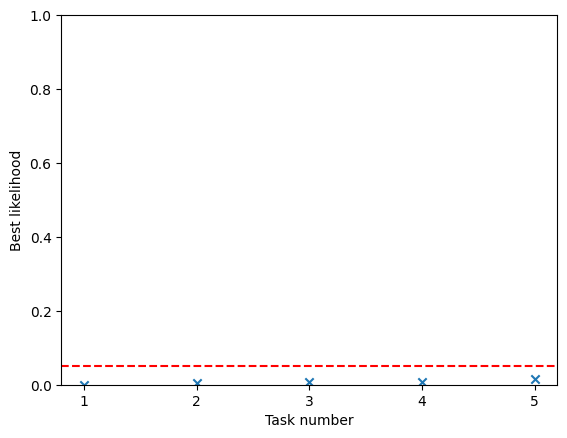

In [ ]:

import matplotlib.pyplot as plt

# Data
categories = ['1', '2', '3', '4', '5']
best_confidences = [0, 0.0047, 0.0072, 0.0066, 0.0148]
horizontal_line_y = 0.05
# Plot
plt.scatter(categories, best_confidences, marker='x', linestyle='-')
plt.axhline(y=horizontal_line_y, color='r', linestyle='--')

# Add labels and title
plt.xlabel('Task number')
plt.ylabel('Best likelihood')

# Set x-axis tick labels
plt.xticks(categories)
# Set y-axis limits
plt.ylim(0, 1)
# Show plot
#kplt.grid(True)
plt.show()